In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [0]:
!ls "/content/drive/My Drive"

 20171109_160428.jpg
 20180207_123616.jpg
 AAvartan
 AI_CHATBOT
 AI_chtbt.ipynb
 another_man_with_varities1.jpg
 another_man_with_varities.jpg
'Anyfile Notepad Files'
 apps
 aril_best_weights11.hdf5
 Classroom
 coat_content.jpg
 coat_style1.jpg
 coat_style2.jpg
 coat_style3.png
 coat_style.jpg
'Colab Notebooks'
'Consulting proposal.gslides'
 content_mask0.png
 content_mask10.png
 content_mask110.png
 content_mask11.png
 content_mask12.png
 content_mask13.png
 content_mask14.png
 content_mask15.png
 content_mask16.png
 content_mask17.png
 content_mask18.png
 content_mask19.png
 content_mask1.png
 content_mask20.png
 content_mask21.png
 content_mask22.png
 content_mask23.png
 content_mask2.png
 content_mask3.png
 content_mask4.png
 content_mask5.png
 content_mask6.png
 content_mask7.png
 content_mask8.png
 content_mask9.png
 content_mask.png
'C++ - The Complete Reference 4e (1) (1).pdf'
'C++ - The Complete Reference 4e (1) (2).pdf'
'C++ - The Complete Reference 4e (1) (3).pdf'
'C++ - The

In [0]:
import tensorflow as tf


import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import itertools 
from tqdm import tqdm 
from imgaug import augmenters as iaa 
from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.model_selection import train_test_split
import time




# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512


import numpy as np
import time
import functools

sys.path.append(str('/content/drive/My Drive'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log







Using TensorFlow backend.


In [0]:
import warnings 
warnings.filterwarnings("ignore")

class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 สำหรับคลาส background
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 100
    
    # เนื่องจาก Kaggle จำกัดเวลาในการรัน kernel ไว้ 9 ชั่วโมง 
    # เราจึงกำหนดค่า STEPS_PER_EPOCH และ VALIDATION_STEPS ให้รันทันในเวลานี้ครับ
    STEPS_PER_EPOCH = 2669
    VALIDATION_STEPS = 100
    
config = FashionConfig()
config.display()

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()



model1 = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir='/content/drive/My Drive/mrcnn')

model_path='/content/drive/My Drive/mask_rcnn_fashion_0003.h5'
print("Loading weights from ", model_path)
model1.load_weights(model_path, by_name=True)











Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [0]:
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle
'''
def refine_masks(masks, rois, class_ids):
    class_pos = np.argsort(class_ids)
    class_rle = to_rle(np.sort(class_ids))
    
    pos = 0
    areas=[]
    
    for i, _ in enumerate(class_rle[::2]):
        previous_pos = pos
        pos += class_rle[2*i+1]
        if pos-previous_pos == 1:
            continue 
        mask_indices = class_pos[previous_pos:pos]
        
        union_mask = np.zeros(masks.shape[:-1], dtype=bool)
        for m in mask_indices:
            masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
            union_mask = np.logical_or(masks[:, :, m], union_mask)
        areas.extend(np.sum(masks.reshape(-1,masks.shape[-1]),axis=0))
        
        for m in mask_indices:
            mask_pos = np.where(masks[:, :, m]==True)
            if np.any(mask_pos):
                y1, x1 = np.min(mask_pos, axis=1)
                y2, x2 = np.max(mask_pos, axis=1)
                rois[m, :] = [y1, x1, y2, x2]
            
    return masks, rois,areas
    '''

def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois,areas

In [0]:

base_image_path = '/content/drive/My Drive/man_shirt.jpg'
style_reference_image_path = '/content/drive/My Drive/men_printed_shirt_8.jpg'
#base_image_path = '/content/drive/My Drive/lady_with_red_denim _skirt.jpg'
#style_reference_image_path = '/content/drive/My Drive/lady_with_jean.jpg'


def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    print(img.shape)
    
    return img
  
  
resize_image(base_image_path)

(512, 512, 3)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [0]:

def funmask(img_path):
    
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = model1.detect([resize_image(img_path)])
    r = result[0]
    names=[]

    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        #masks, rois,areas = refine_masks(masks, rois, r['class_ids'])
        masks, rois,areas = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
            
    
    clsid=r['class_ids']
    return masks,clsid,areas

(512, 512, 3)
content_mask_shape (1500, 1000, 10)
<class 'numpy.ndarray'>
(512, 512, 3)
style_mask_shape (500, 500, 7)
no of ones in content mask 76368
(1500, 1000)
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
(512, 512, 3)


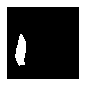

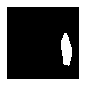

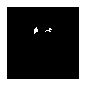

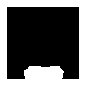

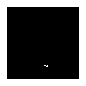

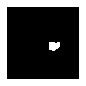

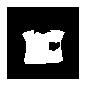

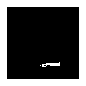

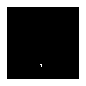

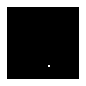

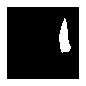

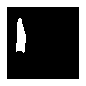

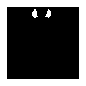

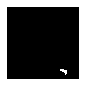

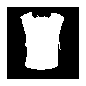

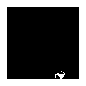

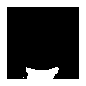

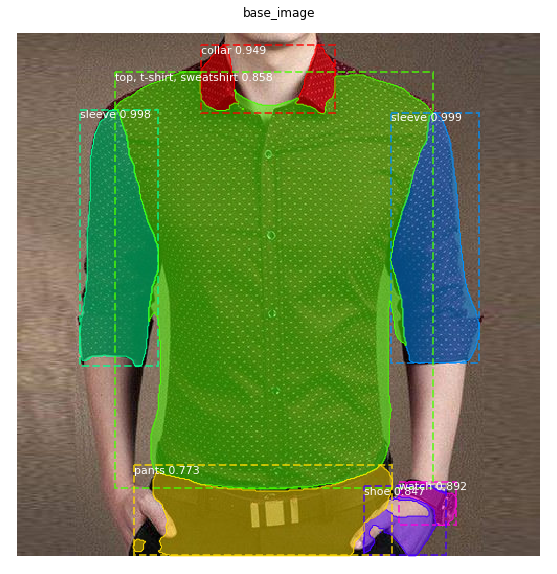

(512, 512, 3)


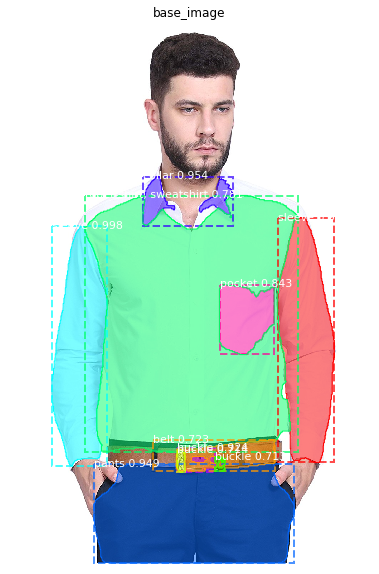

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt



content_mask,content_label,content_areas=funmask(base_image_path)
no_of_content_mask=content_mask.shape[2]
print("content_mask_shape",content_mask.shape)
print(type(content_mask))
style_mask,style_label,style_areas=funmask(style_reference_image_path)
print("style_mask_shape",style_mask.shape)
no_of_style_mask=style_mask.shape[2]
a=np.count_nonzero(content_mask[:,:,1]==1)
print("no of ones in content mask",a)
print(content_mask[:,:,0].shape)
#plt.imshow(content_mask[:,:,0],cmap='gray', interpolation='nearest')
#plt.show()
for i in range(content_mask.shape[2]):
  print(i)
  fig = plt.figure(frameon=False)
  fig.set_size_inches(1,1)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(content_mask[:,:,i],cmap='gray', aspect='auto')
  #fig.savefig(fname, dpi)
  fig.savefig("/content/drive/My Drive/content_mask1"+str(i)+".png",dpi=512)
  

for i in range(style_mask.shape[2]):
  print(i)
  fig = plt.figure(frameon=False)
  fig.set_size_inches(1,1)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(style_mask[:,:,i],cmap='gray', aspect='auto')
  #fig.savefig(fname, dpi)
  fig.savefig("/content/drive/My Drive/style_mask1"+str(i)+".png",dpi=512)
#plt.savefig("/content/drive/My Drive/content_mask.png")
nmask=np.resize(content_mask[:,:,0],(512,512))
#plt.imshow(nmask,cmap='gray', interpolation='nearest')
#plt.show()
with open("/content/drive/My Drive/label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]


image_path = style_reference_image_path
    
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
result = model1.detect([resize_image(image_path)])
r = result[0]
    
if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    y_scale = img.shape[0]/IMAGE_SIZE
    x_scale = img.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

    masks, rois,areas = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']

visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'],
                            title="base_image", figsize=(10, 10))

image_path = base_image_path
    
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = model1.detect([resize_image(image_path)])
r = result[0]
    
if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    y_scale = img.shape[0]/IMAGE_SIZE
    x_scale = img.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

    masks, rois,areas = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']

visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'],
                            title="base_image", figsize=(10, 10))

In [0]:
match={}
for k,i in enumerate(style_label):
    ar=28446744073709388301
    for l,j in enumerate(content_label):
      if(i==j):
        print(i,j)
        print(content_areas[l]-style_areas[k])
      
      if(i==j and (content_areas[l]-style_areas[k])<ar):
        ar=content_areas[l]-style_areas[k]
        print(l,k)
        match[l]=k
            
            
print(match)

32 32
58085
0 0
32 32
63825
32 32
58083
0 1
32 32
63823
29 29
6531
2 2
2 2
228250
6 4
7 7
123892
3 6
{0: 1, 2: 2, 6: 4, 3: 6}


In [0]:
from keras.preprocessing.image import load_img,save_img,img_to_array

In [0]:
from __future__ import print_function
try:
    %tensorflow_version 1.x
except Exception:
    pass
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K

In [0]:
base_image_path = '/content/drive/My Drive/style_image_5.jpg'
style_reference_image_path = '/content/drive/My Drive/style_image_66.jpeg'
##base_image_path = '/content/drive/My Drive/coat_content.jpg'
##style_reference_image_path = '/content/drive/My Drive/coat_style2.jpg'

#base_image_path = '/content/drive/My Drive/lady_with_red_denim _skirt.jpg'
#style_reference_image_path = '/content/drive/My Drive/lady_with_jean.jpg'
base_image_path = '/content/drive/My Drive/man_shirt.jpg'
style_reference_image_path = '/content/drive/My Drive/men_printed_shirt_8.jpg'

result_prefix = '/content/drive/My Drive/results'
path="/content/drive/My Drive/iteration_result1.png"
iterations = 3

In [0]:
content_mask.shape

(932, 620, 7)

In [0]:
'''import scipy
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 512
img_ncols = 512

# util function to open, resize and format pictures into appropriate tensors


def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    l=0
    for m in range(content_mask.shape[-1]):
            if m in match.keys():
                #print(match[m])
                #print(style_outputs[name].shape)
                print('stylemask')
                print((style_mask[:,:,match[m]]).shape)
                print(type(style_mask[:,:,match[m]]))
                st_o=applymask(style,style_mask[:,:,match[m]])
                #print(np.where(style_mask[:,:,match[m]]==1))
                #print(style_mask[:,:,match[m]])
                #print(style_outputs[name])
                #print(st_o)
                st_t=applymask(combination,content_mask[:,:,m])
                #loses.append(tf.reduce_mean((st_o-st_t)**2))
    #style_loss=tf.add_n(loses)
                S = gram_matrix(st_o)
                C = gram_matrix(st_t)
                channels = 3
                size = img_nrows * img_ncols
                l +=K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
    return l 

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

#feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                  'block5_conv1']
#for layer_name in feature_layers:
#    layer_features = outputs_dict[layer_name]
#    style_reference_features = layer_features[1, :, :, :]
#    combination_features = layer_features[2, :, :, :]
#    sl = style_loss(style_reference_features, combination_features)
#    loss = loss + (style_weight / len(feature_layers)) * sl






def read_single_mask(rawmask, hard_width): 
    
    #if hard_width:
    #    rawmask = scipy.misc.imresize(rawmask, float(hard_width) / rawmask.shape[1], interp='nearest')    
     #rawmask = rawmask / 255 # integer division, only pure white pixels become 1
    print(rawmask.shape) 
    rawmask = rawmask.astype(np.float32)  
    rawmask=np.resize(rawmask,(512,512,rawmask.shape[2])) 
    print(rawmask.shape)
    single = (rawmask.transpose([2, 0, 1]))
    print(single.shape)
    return single

target_masks_origin = read_single_mask(content_mask, 512)
print(target_masks_origin.shape)

style_masks_origin = read_single_mask(style_mask, 512)



import numpy as np
import scipy.io

vgg_layers = (
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)


def prepare_model(path):
    vgg_rawnet = scipy.io.loadmat(path)
    return vgg_rawnet['layers'][0] # another solution: global vgg_weights

def build_image_net(input_tensor, vgg_weights, feature_pooling_type):
    net = {}
    current = input_tensor

    for i, name in enumerate(vgg_layers):
        layer_kind = name[:4]
        if layer_kind == 'conv':
            weights, bias = vgg_weights[i][0][0][2][0]
            bias = bias.reshape(-1)
            current = conv_layer(current, tf.constant(weights), tf.constant(bias))
        elif layer_kind == 'relu':
            current = tf.nn.relu(current)
        elif layer_kind == 'pool':
            current = pool_layer(current, feature_pooling_type)
        net[name] = current

    return net

def conv_layer(input, W, b):
    conv =  tf.nn.conv2d(input, W, strides=[1,1,1,1], padding='SAME')
    return conv + b

def pool_layer(input, feature_pooling_type):
    if feature_pooling_type == 'avg':
        return tf.nn.avg_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    elif feature_pooling_type == 'max':
        return tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def build_mask_net(input_tensor, mask_downsample_type):
    net = {}
    current = input_tensor

    # soft
    if mask_downsample_type == 'simple':
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'pool':
                current = tf.nn.avg_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = current
    # hard
    elif mask_downsample_type == 'all':
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'conv':
                current = tf.nn.max_pool(current, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
            elif layer_kind == 'pool':
                current = tf.nn.max_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = current     
    # hard, keep the padding boundary unchanged
    elif mask_downsample_type == 'inside':
        current = 1 - current
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'conv':
                current = tf.nn.max_pool(current, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
            elif layer_kind == 'pool':
                current = tf.nn.max_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = 1 - current 
    # soft
    elif mask_downsample_type == 'mean':
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'conv':
                current = tf.nn.avg_pool(current, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
            elif layer_kind == 'pool':
                current = tf.nn.avg_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = current 

    return net

def build_mask_net(input_tensor):
  net = {}
  current = input_tensor
  print(current.shape)
  

  for name in vgg_layers:
    layer_kind = name[:4]
    if layer_kind == 'conv':
      current = tf.nn.max_pool(current, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
    elif layer_kind == 'pool':
      current = tf.nn.max_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    net[name] = current 
  print(len(net))
  return net

def compute_layer_masks(masks, layers):
  print(masks.shape)
  masks_tf = masks.transpose([1,2,0]) # [numberOfMasks, h, w] -> [h, w, masks]
  masks_tf = masks_tf[np.newaxis, :, :, :] # -> [1, h, w, masks]
  print(masks_tf.shape)
  input = tf.placeholder(tf.float32, shape=masks_tf.shape)
  net = build_mask_net(input) # only do pooling, so no intervention between masks
  layer_masks = {}
  with tf.Session() as sess:
      for layer in layers:
          out = sess.run(net[layer], feed_dict={input: masks_tf})
          layer_masks[layer] = out[0].transpose([2,0,1])
  return layer_masks


def masked_gram(x, mx, mask_norm, N):
    R = mx.shape[0]
    M = mx.shape[1] * mx.shape[2]

    # TODO: use local variable?
    mx = mx.reshape([R, M])
    x = tf.reshape(x, [M, N])
    x = tf.transpose(x) # N * M
    masked_gram = []
    for i in range(R):
        mask = mx[i]
        masked_x = x * mask
        if mask_norm == 'square_sum':
            K = 1. / np.sum(mask**2)
        elif mask_norm == 'sum':
            K = 1. / np.sum(mask)
        gram = K * tf.matmul(masked_x, tf.transpose(masked_x))
        masked_gram.append(gram)
    return tf.stack(masked_gram)

def masked_style_layer_loss(a, ma, x, mx, mask_norm):
    N = a.shape[2]
    print(N)
    R = ma.shape[0]
    print(R)
    R=len(match)
    pp=pow(int(N),2)
    K = 1. / (4. * pp * R)
    pa=[]
    px=[]
    for i in range(len(match)):
      pa.append(ma[match[i]])
      px.append(mx[i])
    pa=np.asarray(pa)
    print('match_array')
    print(pa.shape)
    px=np.asarray(px)
    print('match_array')
    print(px.shape)
    A = masked_gram(a, pa, mask_norm, N)
    G = masked_gram(x, px, mask_norm, N)
    for j,k in
    loss = K * tf.reduce_sum( tf.pow((G - A), 2) )
    return loss

def sum_masked_style_loss(target_masks, style_masks, layers, layers_weights, mask_norm):
    style_loss = 0.
    for layer, weight in zip(layers, layers_weights):
      layer_features = outputs_dict[layer]
      style_reference_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      a = style_reference_features
      ma = style_masks[layer]
      x = combination_features
      mx = target_masks[layer]
      style_loss += masked_style_layer_loss(a, ma, x, mx, mask_norm) * weight
    style_loss /= float(sum(layers_weights))
    return style_loss

style_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
target_masks = compute_layer_masks(target_masks_origin, style_layers)
style_masks = compute_layer_masks(style_masks_origin, style_layers)
style_layers_weights=[1., 1., 1., 1., 1.]

style_masked_loss = sum_masked_style_loss(target_masks, style_masks, 
                                              style_layers, style_layers_weights, 
                                              'square_sum')






loss = loss + style_masked_loss + total_variation_weight * total_variation_loss(combination_image)


# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(5):
  
  
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    
    print('Current loss value:', min_val)
    #save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_new_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
print('Iteration %d completed in %ds' % (i, end_time - start_time))
from IPython.display import Image
Image(path)
Image(path1)



import os
import sys
import tensorflow as tf
import numpy as np
import scipy.misc
from sklearn.cluster import KMeans
import model
import parser


'''

'''
def read_image(path, hard_width):   # read and preprocess
    img = scipy.misc.imread(path)      
    if hard_width:
        img = scipy.misc.imresize(img, float(hard_width) / img.shape[1])
    img = img.astype(np.float32)
    img = img[np.newaxis, :, :, :]
    img = img - [123.68, 116.779, 103.939]
    return img

def read_single_mask(path, hard_width): 
    rawmask = scipy.misc.imread(path)
    if hard_width:
        rawmask = scipy.misc.imresize(rawmask, float(hard_width) / rawmask.shape[1], interp='nearest')    
    rawmask = rawmask / 255 # integer division, only pure white pixels become 1
    rawmask = rawmask.astype(np.float32)   
    single = (rawmask.transpose([2, 0, 1]))[0]
    return np.stack([single])

# colorful, run K-Means to get rid of possible intermediate colors

def read_colorful_mask(target_path, style_path, hard_width, n_colors):
    if target_path is None or style_path is None:
        raise AttributeError("mask path can't be empty when n_colors > 1 ")

    target_mask = scipy.misc.imread(target_path)
    style_mask = scipy.misc.imread(style_path)
    if hard_width: # use 'nearest' to avoid more intermediate colors
        target_mask = scipy.misc.imresize(target_mask, float(hard_width) / target_mask.shape[1], 
            interp='nearest') 
        style_mask = scipy.misc.imresize(style_mask, float(hard_width) / style_mask.shape[1], 
            interp='nearest')
    
    # flatten
    target_shape = target_mask.shape[0:2]
    target_mask = target_mask.reshape([target_shape[0]*target_shape[1], -1])
    style_shape = style_mask.shape[0:2]
    style_mask = style_mask.reshape([style_shape[0]*style_shape[1], -1])

    # cluster
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(style_mask)

    # predict
    target_labels = kmeans.predict(target_mask.astype(np.float32))
    target_labels = target_labels.reshape([target_shape[0], target_shape[1]])
    style_labels = kmeans.predict(style_mask.astype(np.float32))
    style_labels = style_labels.reshape([style_shape[0], style_shape[1]])

    # stack
    target_masks = []
    style_masks = []
    for i in range(n_colors):
        target_masks.append( (target_labels == i).astype(np.float32) )
        style_masks.append( (style_labels == i).astype(np.float32) )
    return np.stack(target_masks), np.stack(style_masks)

def write_image(path, img):   # postprocess and write
    img = img + [123.68, 116.779, 103.939]
    img = img[0]
    img = np.clip(img, 0, 255).astype('uint8')
    scipy.misc.imsave(path, img)

def get_init_image(content_img, init_noise_ratio):
    # why [-20, 20]???
    noise_img = np.random.uniform(-20., 20., content_img.shape).astype(np.float32)
    init_img = init_noise_ratio * noise_img + (1. - init_noise_ratio) * content_img
    return init_img


'''
    
'''
def compute_features(vgg_weights, pooling_type, input_img, layers):
    input = tf.placeholder(tf.float32, shape=input_img.shape)
    net = Model.build_image_net(input, vgg_weights, pooling_type)
    features = {}
    with tf.Session() as sess:
        for layer in layers:
            features[layer] = sess.run(net[layer], feed_dict={input: input_img})
    return features

def compute_layer_masks(masks, layers, ds_type):
    masks_tf = masks.transpose([1,2,0]) # [numberOfMasks, h, w] -> [h, w, masks]
    masks_tf = masks_tf[np.newaxis, :, :, :] # -> [1, h, w, masks]

    input = tf.placeholder(tf.float32, shape=masks_tf.shape)
    net = Model.build_mask_net(input, ds_type) # only do pooling, so no intervention between masks
    layer_masks = {}
    with tf.Session() as sess:
        for layer in layers:
            out = sess.run(net[layer], feed_dict={input: masks_tf})
            layer_masks[layer] = out[0].transpose([2,0,1])
    return layer_masks

def build_target_net(vgg_weights, pooling_type, target_shape):
    input = tf.Variable( np.zeros(target_shape).astype('float32') )
    net = Model.build_image_net(input, vgg_weights, pooling_type)
    net['input'] = input
    return net


'''
    loss
'''
def content_layer_loss(p, x, loss_norm):
    _, h, w, d = p.shape
    M = h * w
    N = d
    if loss_norm  == 1:
        K = 1. / (N * M)
    elif loss_norm == 2:
        K = 1. / (2. * N**0.5 * M**0.5)
    loss = K * tf.reduce_sum( tf.pow((x - p), 2) )
    return loss    

def sum_content_loss(target_net, content_features, layers, layers_weights, loss_norm):
    content_loss = 0.
    for layer, weight in zip(layers, layers_weights):
        p = content_features[layer]
        x = target_net[layer]
        content_loss += content_layer_loss(p, x, loss_norm) * weight
    content_loss /= float(sum(layers_weights))
    return content_loss

def masked_gram(x, mx, mask_norm, N):
    R = mx.shape[0]
    M = mx.shape[1] * mx.shape[2]

    # TODO: use local variable?
    mx = mx.reshape([R, M])
    x = tf.reshape(x, [M, N])
    x = tf.transpose(x) # N * M
    masked_gram = []
    for i in range(R):
        mask = mx[i]
        masked_x = x * mask
        if mask_norm == 'square_sum':
            K = 1. / np.sum(mask**2)
        elif mask_norm == 'sum':
            K = 1. / np.sum(mask)
        gram = K * tf.matmul(masked_x, tf.transpose(masked_x))
        masked_gram.append(gram)
    return tf.stack(masked_gram)

def masked_style_layer_loss(a, ma, x, mx, mask_norm):
    N = a.shape[3]
    R = ma.shape[0]
    K = 1. / (4. * N**2 * R)
    A = masked_gram(a, ma, mask_norm, N)
    G = masked_gram(x, mx, mask_norm, N)
    loss = K * tf.reduce_sum( tf.pow((G - A), 2) )
    return loss

def sum_masked_style_loss(target_net, style_features, target_masks, style_masks, layers, layers_weights, mask_norm):
    style_loss = 0.
    for layer, weight in zip(layers, layers_weights):
        a = style_features[layer]
        ma = style_masks[layer]
        x = target_net[layer]
        mx = target_masks[layer]
        style_loss += masked_style_layer_loss(a, ma, x, mx, mask_norm) * weight
    style_loss /= float(sum(layers_weights))
    return style_loss

def gram_matrix(x): 
    _, h, w, d = x.get_shape() # x is a tensor
    M = h.value * w.value
    N = d.value    
    F = tf.reshape(x, (M, N))
    G = tf.matmul(tf.transpose(F), F)
    return (1./M) * G

def style_layer_loss(a, x):
    N = a.shape[3]
    A = gram_matrix(tf.convert_to_tensor(a))
    G = gram_matrix(x)
    loss = (1./(4 * N**2 )) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

def sum_style_loss(target_net, style_features, layers, layers_weights): # for testing  
    style_loss = 0.
    for layer, weight in zip(layers, layers_weights):
        a = style_features[layer]
        x = target_net[layer]
        style_loss += style_layer_loss(a, x) * weight
    style_loss /= float(sum(layers_weights))
    return style_loss    

def sum_total_variation_loss(input, shape):
    b, h, w, d = shape
    x = input
    tv_y_size = b * (h-1) * w * d
    tv_x_size = b * h * (w-1) * d
    loss_y = tf.nn.l2_loss(x[:,1:,:,:] - x[:,:-1,:,:])  # l2_loss() use 1/2 factor
    loss_y /= tv_y_size
    loss_x = tf.nn.l2_loss(x[:,:,1:,:] - x[:,:,:-1,:]) 
    loss_x /= tv_x_size
    loss = 2 * (loss_y + loss_x)
    loss = tf.cast(loss, tf.float32) # ?
    return loss


'''
    
'''
def  main(args):

    '''
    
    '''  
    # read images and preprocess
    if args.content_img:
        content_img = read_image(args.content_img, args.hard_width) 
    style_img = read_image(args.style_img, args.hard_width) 

    # get stacked 0./1. masks
    if args.mask_n_colors > 1: # colorful
        target_masks_origin, style_masks_origin = read_colorful_mask(args.target_mask, args.style_mask, 
                                                    args.hard_width, args.mask_n_colors)    
    
    else: # single mask
        if args.target_mask is None:
            if args.content_img:
                target_masks_origin = np.ones(content_img.shape[0:3]).astype(np.float32)
            else:
                target_masks_origin = np.ones(style_img.shape[0:3]).astype(np.float32)   
        else:
            target_masks_origin = read_single_mask(args.target_mask, args.hard_width)

        if args.style_mask is None:
            style_masks_origin = np.ones(style_img.shape[0:3]).astype(np.float32)
        else:
            style_masks_origin = read_single_mask(args.style_mask, args.hard_width)

    # init img & target shape
    if args.content_img:
        target_shape = content_img.shape
        init_img = get_init_image(content_img, args.init_noise_ratio)
    else:
        target_shape = [1] + list(target_masks_origin.shape[1:3]) + [3]
        init_img = np.random.uniform(-20., 20., target_shape).astype(np.float32)

    # check shape & number of masks
    if args.content_img and content_img.shape[1:3] != target_masks_origin.shape[1:3]:
        print('content and mask have different shape')
        sys.exit(0)
    if style_img.shape[1:3] != style_masks_origin.shape[1:3]:
        print('style and mask have different shape')
        sys.exit(0)
    if target_masks_origin.shape[0] != style_masks_origin.shape[0]:
        print('content and style have different masks')
        sys.exit(0)

    '''
    
    '''
    # prepare model weights
    vgg_weights = Model.prepare_model(args.model_path)

    # feature maps of specific layers
    if args.content_img:
        content_features = compute_features(vgg_weights, args.feature_pooling_type, 
            content_img, args.content_layers)   
    style_features = compute_features(vgg_weights, args.feature_pooling_type, 
        style_img, args.style_layers)

    # masks of specific layers
    target_masks = compute_layer_masks(target_masks_origin, args.style_layers, 
        args.mask_downsample_type)
    style_masks = compute_layer_masks(style_masks_origin, args.style_layers, 
        args.mask_downsample_type)

    # build net
    target_net = build_target_net(vgg_weights, args.feature_pooling_type, target_shape)


    '''

    '''
    if args.content_img:
        content_loss = sum_content_loss(target_net, content_features, 
                                        args.content_layers, args.content_layers_weights,
                                        args.content_loss_normalization)
    else:
        content_loss = 0.

    style_masked_loss = sum_masked_style_loss(target_net, style_features, 
                                              target_masks, style_masks, 
                                              args.style_layers, args.style_layers_weights, 
                                              args.mask_normalization_type)

    if args.tv_weight != 0.:
        tv_loss = sum_total_variation_loss(target_net['input'], target_shape)
    else:
        tv_loss = 0.

    total_loss = args.content_weight * content_loss + \
                 args.style_weight * style_masked_loss + \
                 args.tv_weight * tv_loss


    '''
     
    '''
    if not os.path.exists(args.output_dir):
        os.mkdir(args.output_dir)

    if args.optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(args.learning_rate)
        train_op = optimizer.minimize(total_loss)
        #init
        init_op = tf.global_variables_initializer() # must! Adam has some varibales to init
        sess = tf.Session()
        sess.run(init_op)
        sess.run( target_net['input'].assign(init_img) )
        #train
        for i in range(args.iteration):
            sess.run(train_op)
            if i % args.log_iteration == 0:
                print('Iteration %d: loss = %f' % (i+1, sess.run(total_loss)))
                result = sess.run(target_net['input'])
                output_path = os.path.join(args.output_dir, 'result_%s.png' % (str(i).zfill(4)))
                write_image(output_path, result)
    
    elif args.optimizer == 'lbfgs':
        optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            total_loss, method='L-BFGS-B',
            options={'maxiter': args.iteration,
                     'disp': args.log_iteration})   
        # init  
        init_op = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init_op)
        sess.run( target_net['input'].assign(init_img) )
        # train
        optimizer.minimize(sess)    


    '''
    
    '''
    print('Iteration %d: loss = %f' % (args.iteration, sess.run(total_loss)))
    result = sess.run(target_net['input'])
    output_path = os.path.join(args.output_dir, 'result_final.png')
    write_image(output_path, result)


if __name__ == '__main__':   
    args = Parser.parse_args()
    main(args)


IndentationError: ignored

In [0]:
import tensorflow as tf
tf.executing_eagerly()
import numpy as np
import scipy.io
import argparse

content_img=base_image_path
style_img=style_reference_image_path
#target_masks1="/content/drive/My Drive/"
#style_masks1="/content/drive/My Drive/"

mask_n_colors=1
hard_width=512
init_noise_ratio=512
model_path='/content/drive/My Drive/Colab Notebooks/imagenetvggverydeep19mat/imagenet-vgg-verydeep-19.mat'
feature_pooling_type='avg'
mask_downsample_type='simple'
content_layers=['relu4_2']
content_layers_weights=[1.]
style_layers=['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_layers_weights=[1., 1., 1., 1., 1.]
content_loss_normalization=1
mask_normalization_type='square_sum',
content_weight=1.
style_weight=0.2
tv_weight=0.
optimizer='lbfgs'
learning_rate=10.
iteration=1000
log_iteration=10
output_dir='/content/drive/My Drive/output'
'''if not os.path.exists(output_dir):
  os.makedirs(output_dir)'''
'''
def parse_args():
    parser = argparse.ArgumentParser()

# ('--weights', nargs='+', type=float, default=[1.0], choices=[1, 2, 3], help='')

    parser.add_argument('--content_img', type=str,default=base_image_path,
                        help='content image path')

    parser.add_argument('--style_img', type=str,default=style_reference_image_path,
                        help='style image path')

    parser.add_argument('--target_mask', type=str,
                        help='target mask path')

    parser.add_argument('--style_mask', type=str,
                        help='style mask path')

    # colors = 1: only use white region
    # colors > 1: use all colors
    parser.add_argument('--mask_n_colors', type=int,
                        default=1,
                        help='Number of colors in the given mask')

    parser.add_argument('--hard_width', type=int,default=512,
                        help='If set, resize the content, style and mask images to the same width')

    parser.add_argument('--init_noise_ratio', type=float,
                        default=0.0,
                        help='The ratio between noise and content, ranging from 0. to 1.')

    parser.add_argument('--model_path', type=str,
                        default=,
                        help='The path of the vgg model')

    parser.add_argument('--feature_pooling_type', type=str,
                        default='avg',
                        choices=['avg', 'max'],
                        help='pooling type of the vgg model')

    parser.add_argument('--mask_downsample_type', type=str,
                        default='simple',
                        choices=['simple', 'all', 'inside', 'mean'],
                        help='How to propagate masks to different layers')

    parser.add_argument('--content_layers', nargs='+', type=str,
                        default=['relu4_2'],
                        help='VGG19 layers used for the content image')

    parser.add_argument('--content_layers_weights', nargs='+', type=float,
                        default=[1.],
                        help='weights of each content layer')

    parser.add_argument('--style_layers', nargs='+', type=str,
                        default=['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],
                        help='VGG19 layers used for the style image')

    parser.add_argument('--style_layers_weights', nargs='+', type=float,
                        default=[1., 1., 1., 1., 1.],
                        help='weights of each style layer')

    parser.add_argument('--content_loss_normalization', type=int,
                        default=1,
                        choices=[1, 2],
                        help='1 for 1./(N * M); 2 for 1./(2. * N**0.5 * M**0.5)')

    parser.add_argument('--mask_normalization_type', type=str,
                        default='square_sum',
                        choices=['square_sum', 'sum'],
                        help='How to normalize a masked gram matrix')

    parser.add_argument('--content_weight', type=float,
                        default=1.,
                        help='Content loss weight')

    parser.add_argument('--style_weight', type=float,
                        default=0.2,
                        help='Style loss weight')

    parser.add_argument('--tv_weight', type=float,
                        default=0.,
                        help='Total variation loss weight')

    parser.add_argument('--optimizer', type=str,
                        default='lbfgs',
                        choices=['lbfgs', 'adam'],
                        help='choose optimizer')

    parser.add_argument('--learning_rate', type=float,
                        default=10.,
                        help='learning rate for adam optimizer')

    parser.add_argument('--iteration', type=int,
                        default=1000,
                        help='max iterations of training')

    # 10 is good for l-bfgs interface?
    parser.add_argument('--log_iteration', type=int,
                        default=10,
                        help='Number of iterations to print loss. For adam, also save intermediate result. For L-BFGS, don\'t larger than 10')

    parser.add_argument('--output_dir', type=str,
                        default='./output',
                        help='Directory to save result')

    return parser.parse_args()'''
vgg_layers = (
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)


def prepare_model(path):
    vgg_rawnet = scipy.io.loadmat(path)
    return vgg_rawnet['layers'][0] # another solution: global vgg_weights

def build_image_net(input_tensor, vgg_weights, feature_pooling_type):
    net = {}
    current = input_tensor

    for i, name in enumerate(vgg_layers):
        layer_kind = name[:4]
        if layer_kind == 'conv':
            weights, bias = vgg_weights[i][0][0][2][0]
            bias = bias.reshape(-1)
            current = conv_layer(current, tf.constant(weights), tf.constant(bias))
        elif layer_kind == 'relu':
            current = tf.nn.relu(current)
        elif layer_kind == 'pool':
            current = pool_layer(current, feature_pooling_type)
        net[name] = current

    return net

def conv_layer(input, W, b):
    conv =  tf.nn.conv2d(input, W, strides=[1,1,1,1], padding='SAME')
    return conv + b

def pool_layer(input, feature_pooling_type):
    if feature_pooling_type == 'avg':
        return tf.nn.avg_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    elif feature_pooling_type == 'max':
        return tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def build_mask_net(input_tensor, mask_downsample_type):
    net = {}
    current = input_tensor

    # soft
    if mask_downsample_type == 'simple':
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'pool':
                current = tf.nn.avg_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = current
    # hard
    elif mask_downsample_type == 'all':
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'conv':
                current = tf.nn.max_pool(current, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
            elif layer_kind == 'pool':
                current = tf.nn.max_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = current     
    # hard, keep the padding boundary unchanged
    elif mask_downsample_type == 'inside':
        current = 1 - current
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'conv':
                current = tf.nn.max_pool(current, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
            elif layer_kind == 'pool':
                current = tf.nn.max_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = 1 - current 
    # soft
    elif mask_downsample_type == 'mean':
        for name in vgg_layers:
            layer_kind = name[:4]
            if layer_kind == 'conv':
                current = tf.nn.avg_pool(current, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
            elif layer_kind == 'pool':
                current = tf.nn.avg_pool(current, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            net[name] = current 

    return net

import torch
'''def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std'''

def calc_mean_std(feat, eps=1e-5):
  size=tf.shape(feat)
  N=size[0]
  C=size[1]
  feat_var,feat_mean=tf.nn.moments(tf.reshape(feat,[N,C,-1]),axes=2)
  feat_var=feat_var+eps
  feat_std=tf.reshape(tf.math.sqrt(feat_var),[N,C,1,1])
  feat_mean=tf.reshape(feat_mean,[N,C,1,1])
  return feat_mean,feat_std

'''def mean_variance_norm(feat):
    size = feat.size()
    mean, std = calc_mean_std(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat'''

def mean_variance_norm(feat):
  size=tf.shape(feat)
  mean,std=calc_mean_std(feat)
  '''size1=tf.get_shape(mean).as_list()
  size2=tf.get_shape(std).as_list()
  print(size1,size2)'''
  print(mean.shape)
  print(feat.shape)
  normalised_feat=(feat-tf.tile(mean, multiples=(1,1,size[2],size[3])))/tf.tile(std, multiples=(1,1,size[2],size[3]))
  return normalised_feat

'''   
class SANet(torch.nn.Module):
    def __init__(self, in_planes):
        super(SANet, self).__init__()
        self.f = torch.nn.Conv2d(in_planes, in_planes, (1, 1))
        self.g = torch.nn.Conv2d(in_planes, in_planes, (1, 1))
        self.h = torch.nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = torch.nn.Softmax(dim = -1)
        self.out_conv = torch.nn.Conv2d(in_planes, in_planes, (1, 1))
    def forward(self, content, style):
        F = self.f(mean_variance_norm(content))
        G = self.g(mean_variance_norm(style))
        H = self.h(style)
        b, c, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        b, c, h, w = G.size()
        G = G.view(b, -1, w * h)
        S = torch.bmm(F, G)
        S = self.sm(S)
        b, c, h, w = H.size()
        H = H.view(b, -1, w * h)
        O = torch.bmm(H, S.permute(0, 2, 1))
        b, c, h, w = content.size()
        O = O.view(b, c, h, w)
        O = self.out_conv(O)
        O += content
        return O
'''


def SANet(content,style,in_planes):
  #content = tf.keras.layers.Input(shape=content.shape)
  #style=tf.keras.layers.Input(shape=style.shape)
  print(in_planes)
  print("content_shape",content.shape)
  print(mean_variance_norm(content).shape)
  F=tf.keras.layers.Conv2D(in_planes, (1, 1), padding="same", activation="relu")(tf.transpose(content,perm=[0,2,3,1]))
  print('F_shape',F.shape)
  G=tf.keras.layers.Conv2D(in_planes, (1, 1), padding="same", activation="relu")(tf.transpose(style,perm=[0,2,3,1]))
  H=tf.keras.layers.Conv2D(in_planes, (1, 1), padding="same", activation="relu")(tf.transpose(style,perm=[0,2,3,1]))
  f_size = F.shape
  
  F=tf.transpose(tf.reshape(F,[f_size[0],-1,f_size[1]*f_size[2]]),perm=[0,2,1])
  #F=tf.reshape(F,[f_size[0],-1,f_size[1],f_size[2]])
  print("F_shape_after_transpose",F.shape)
  g_size = tf.shape(G)
  G=tf.reshape(G,[g_size[0],-1,g_size[1]*g_size[2]])
  S=tf.matmul(F,G)
  S=tf.keras.activations.softmax(S,axis=-1)
  #S=tf.reshape(S,[g_size[0],-1,g_size[1]*g_size[2]])
  h_size = tf.shape(H)
  H=tf.reshape(H,[h_size[0],-1,h_size[1]*h_size[2]])
  #O=tf.matmul(H,S)
  O=tf.matmul(H,tf.transpose(S,perm=[0,2,1]))
  content_size = tf.shape(content)
  O=tf.reshape(O,[content_size[0],content_size[1],content_size[2],content_size[3]])
  O=tf.keras.layers.Conv2D(in_planes, (1, 1), padding="same", activation="relu")(tf.transpose(O,perm=[0,2,3,1]))
  #O=tf.keras.Model(inputs=[content,style],outputs=O)
  return O

def newSANet(content,style):
  content_size = content.shape
  
  #content=tf.transpose(tf.reshape(content,[content_size[0],-1,content_size[2]*content_size[3]]),perm=[0,2,1])
  #F=tf.reshape(F,[f_size[0],-1,f_size[1],f_size[2]])
  print("F_shape_after_transpose",content.shape)
  style_size = tf.shape(style)
  #style=tf.reshape(style,[style_size[0],-1,style_size[2]*style_size[3]])
  S=tf.matmul(content,style)
  S=tf.transpose(S,perm=[0,2,3,1])
  S=tf.keras.activations.softmax(S,axis=-1)
  
  O=tf.matmul(style,tf.transpose(S,perm=[0,3,1,2]))
  
  #O=tf.reshape(O,[content_size[0],content_size[1],content_size[2],content_size[3]])
  return O

  

(1500, 1000, 10)

512 512


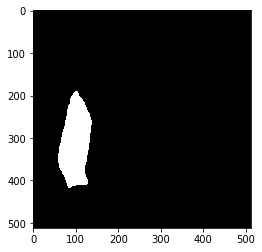

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
249794
mask_shape (1, 512, 512)
512 512


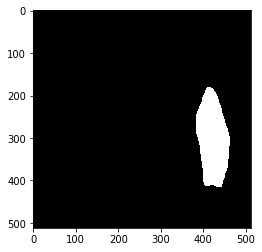

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
248793
mask_shape (1, 512, 512)
512 512


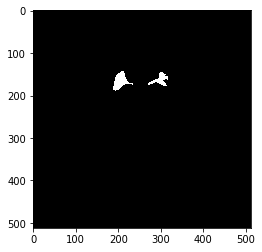

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
260468
mask_shape (1, 512, 512)
512 512


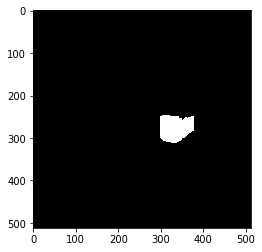

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
257952
mask_shape (1, 512, 512)
512 512


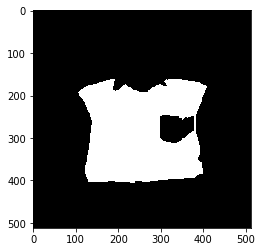

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
206481
mask_shape (1, 512, 512)
512 512


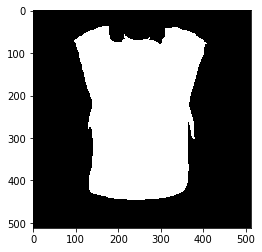

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
167567
mask_shape (1, 512, 512)
512 512


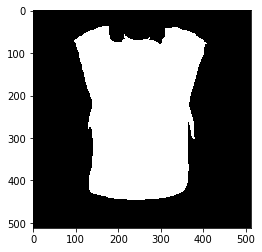

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
167567
mask_shape (1, 512, 512)
512 512


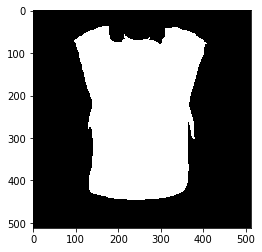

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
167567
mask_shape (1, 512, 512)
512 512


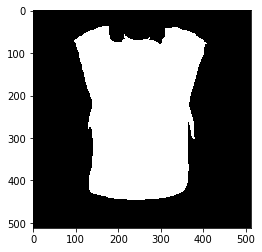

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
167567
mask_shape (1, 512, 512)
512 512


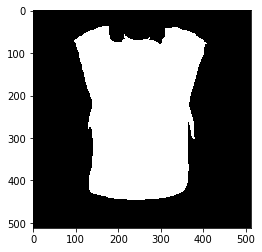

gray_rawmask_shape (512, 512)
mask_shape (512, 512)
167567
mask_shape (1, 512, 512)
target_masks_origin.shape (1, 512, 512)
target_mask_origin_shape (1, 512, 512)
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
masks_ts_shape (1, 512, 512, 1)
relu1_1
relu2_1
relu3_1
relu4_1
relu5_1
a_shape (1, 512, 512, 64)
F_shape_after_transpose (1, 64, 512, 512)
fc_shape (1, 64, 512, 512)
maskc_shape (1, 64, 51

KeyboardInterrupt: ignored

In [0]:
import os
import sys
import tensorflow as tf
import numpy as np
import scipy.misc
from sklearn.cluster import KMeans
import imageio
from skimage.transform import resize
from PIL import Image
#im = imageio.imread('astronaut.png')
#import model
#import parser


'''
    read & write & init
'''

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])


def read_image(path, hard_width):# read and preprocess
    img =Image.open(path)
    height,width=img.size
    #img = imageio.imread(path)      
    if hard_width:
        #img = scipy.misc.imresize(img, float(hard_width) / img.shape[1])
        #img = img.resize(int(hard_width / height))
        img=np.array(img.resize((512,512)))
        #numpy.array(Image.fromarray(arr).resize())
    img = img.astype(np.float32)
    img = img[np.newaxis, :, :, :]
    img = img - [123.68, 116.779, 103.939]
    return img

def read_single_mask(no_of_masks,path, hard_width,mask_type,i):
  masks=[]
  #for i in range(no_of_masks):
  rawmask=Image.open("/content/drive/My Drive/"+mask_type+str(i)+".png")
  h,w=rawmask.size
  print(h,w)
  rawmask.resize((512,512))
  
  #height,width = rawmask.size
  #rawmask = rawmask.resize((512,512), resample=Image.NEAREST)
  rawmask=np.array(rawmask)
  #img_gray = 255 - rawmask[:, :, 3]

  
  rawmask=rgb2gray(rawmask)
  rawmask=np.where(rawmask>0,1,0)
  plt.imshow(rawmask, cmap='gray')
  plt.show()
  print("gray_rawmask_shape",rawmask.shape)
  #rawmask=(rawmask.transpose([2, 0, 1]))[0]
  rawmask = rawmask.astype(np.float32) 
  print("mask_shape",rawmask.shape)
  print(np.count_nonzero(rawmask==0))
 
  ###masks.append(rawmask)
  print("mask_shape",np.stack([rawmask]).shape)

  '''rawmask=Image.open(path)
  height,width = rawmask.size
  #rawmask = imageio.imread(path)
  ##shap=path.shape
  #print('mask_shape',shap)
  if hard_width:
      rawmask = rawmask.resize((512,512), resample=PIL.Image.NEAREST)
      ##rawmask=np.resize(path,(512,512,shap[2]))    
      #rawmask = np.array(rawmask.resize((512,512), resample=PIL.Image.NEAREST))  
  #print(rawmask.shape) 
  ##rawmask = rawmask / 255 # integer division, only pure white pixels become 1
  rawmask = rawmask.astype(np.float32)   
  single = (rawmask.transpose([2, 0, 1]))[0]
  return np.stack([single])'''
  return np.stack([rawmask])

# colorful, run K-Means to get rid of possible intermediate colors
'''def read_colorful_mask(target_path, style_path, hard_width, n_colors):
    if target_path is None or style_path is None:
        raise AttributeError("mask path can't be empty when n_colors > 1 ")

    target_mask = scipy.misc.imread(target_path)
    style_mask = scipy.misc.imread(style_path)
    if hard_width: # use 'nearest' to avoid more intermediate colors
        target_mask = scipy.misc.imresize(target_mask, float(hard_width) / target_mask.shape[1], 
            interp='nearest') 
        style_mask = scipy.misc.imresize(style_mask, float(hard_width) / style_mask.shape[1], 
            interp='nearest')
    
    # flatten
    target_shape = target_mask.shape[0:2]
    target_mask = target_mask.reshape([target_shape[0]*target_shape[1], -1])
    style_shape = style_mask.shape[0:2]
    style_mask = style_mask.reshape([style_shape[0]*style_shape[1], -1])

    # cluster
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(style_mask)

    # predict
    target_labels = kmeans.predict(target_mask.astype(np.float32))
    target_labels = target_labels.reshape([target_shape[0], target_shape[1]])
    style_labels = kmeans.predict(style_mask.astype(np.float32))
    style_labels = style_labels.reshape([style_shape[0], style_shape[1]])

    # stack
    target_masks = []
    style_masks = []
    for i in range(n_colors):
        target_masks.append( (target_labels == i).astype(np.float32) )
        style_masks.append( (style_labels == i).astype(np.float32) )
    return np.stack(target_masks), np.stack(style_masks)'''
#from IPython.display import Image, display
#display(Image('1.png'))
def write_image(path, img):   # postprocess and write
    img = img + [123.68, 116.779, 103.939]
    img = img[0]
    img = np.clip(img, 0, 255).astype('uint8')
    img=Image.fromarray(img)
    img.save(path)
    #display(Image(img))
    #scipy.misc.imsave(path, img)

def get_init_image(content_img, init_noise_ratio):
    # why [-20, 20]???
    noise_img = np.random.uniform(-20., 20., content_img.shape).astype(np.float32)
    init_img = init_noise_ratio * noise_img + (1. - init_noise_ratio) * content_img
    return init_img


'''
    compute features & masks 
    build net
'''
def compute_features(vgg_weights, pooling_type, input_img, layers):
    input = tf.placeholder(tf.float32, shape=input_img.shape)
    net = build_image_net(input, vgg_weights, pooling_type)
    features = {}
    #print(layers)
  
    with tf.Session() as sess:
        for layer in layers:
            #print(layer)
            features[layer] = sess.run(net[layer], feed_dict={input: input_img})
    return features

def compute_layer_masks(masks, layers, ds_type):
    #masks_tf = masks.transpose([1,2,0]) # [numberOfMasks, h, w] -> [h, w, masks]
    #masks_tf = masks[np.newaxis, :, :, :] # -> [1, h, w, masks]
    masks_tf = masks[ :, :, :,np.newaxis]
    print('masks_ts_shape',masks_tf.shape)
    #masks_tf=masks
    input = tf.placeholder(tf.float32, shape=masks_tf.shape)
    net = build_mask_net(input, ds_type) # only do pooling, so no intervention between masks
    layer_masks = {}
    with tf.Session() as sess:
        for layer in layers:
            print(layer)
            out = sess.run(net[layer], feed_dict={input: masks_tf})
            layer_masks[layer] = out[0].transpose([2,0,1])
    return layer_masks

def build_target_net(vgg_weights, pooling_type, target_shape):
    input = tf.Variable( np.zeros(target_shape).astype('float32') )
    net = build_image_net(input, vgg_weights, pooling_type)
    net['input'] = input
    return net


'''
    loss
'''
def content_layer_loss(p, x, loss_norm):
    _, h, w, d = p.shape
    M = h * w
    N = d
    if loss_norm  == 1:
        K = 1. / (N * M)
    elif loss_norm == 2:
        K = 1. / (2. * N**0.5 * M**0.5)
    loss = K * tf.reduce_sum( tf.pow((x - p), 2) )
    return loss    

def sum_content_loss(target_net, content_features, layers, layers_weights, loss_norm):
    content_loss = 0.
    for layer, weight in zip(layers, layers_weights):
        p = content_features[layer]
        x = target_net[layer]
        content_loss += content_layer_loss(p, x, loss_norm) * weight
    content_loss /= float(sum(layers_weights))
    return content_loss

def masked_gram(x, mx, mask_norm, N):
    R = mx.shape[0]
    #print("mxshape",mx.shape)
    #print("R",R)
    M = mx.shape[1] * mx.shape[2]

    # TODO: use local variable?
    mx = mx.reshape([R, M])
    x = tf.reshape(x, [M, N])
    x = tf.transpose(x) # N * M
    masked_gram = []
    for i in range(R):
        #print("i",i)
        mask = mx[i]
        masked_x = x * mask
        if mask_norm == 'square_sum':
            K = 1. / np.sum(mask**2)
        elif mask_norm == 'sum':
            K = 1. / np.sum(mask)
        gram = K * tf.matmul(masked_x, tf.transpose(masked_x))
        masked_gram.append(gram)
    return tf.stack(masked_gram)

def masked_style_layer_loss(a, ma, x, mx, mask_norm):
    N = a.shape[3]
    R = ma.shape[0]
    #print("R",R)
    K = 1. / (4. * N**2 * R)
    A = masked_gram(a, ma, mask_norm, N)
    G = masked_gram(x, mx, mask_norm, N)
    ls=0
    #print(tf.shape(G))
    #print(tf.shape(A))
    #print(len(content_label))
    #print(len(match))
    print('G.shape',G.shape)
    print('A.shape',A.shape)
    #print('G[0].shape',G[0].shape)
    '''for l in range(len(match)):
      ls+=tf.reduce_sum(tf.pow((G[l,:,:] - A[match[l],:,:]), 2))
      #print('ls',ls)
    loss=k*ls'''
    loss = K * tf.reduce_sum( tf.pow((G - A), 2) )
    return loss


##implementing fc content loss and fc style loss

def fc_masked(x, mx, mask_norm, N):
    R = mx.shape[0]
    a1=mx.shape[1] 
    a2=mx.shape[2] 
    M = mx.shape[1] * mx.shape[2]

    # TODO: use local variable?
    mx = mx.reshape([R, M])
    x = tf.reshape(x, [M, N])
    x = tf.transpose(x)
    
    '''x = tf.reshape(x, [mx.shape[2],mx.shape[3], N])
    x = tf.transpose(x,perm=[2,0,1]) # N * M'''
    masked_gram = []
    for i in range(R):
        #print("i",i)
        mask = mx[i]
        masked_x = x * mask
        
        masked_gram.append(tf.reshape(masked_x,[ N,a1,a2]))
    return tf.stack(masked_gram)

def fc_gram(mask, mask_norm, N):
    #R = mx.shape[0]
    #print("mxshape",mx.shape)
    #print("R",R)
    M = mask.shape[2] * mask.shape[3]
    x=mask

    # TODO: use local variable?
    #mx = mx.reshape([R, M])
    x = tf.reshape(x, [M, N])
    x = tf.transpose(x) # N * M
    '''if mask_norm == 'square_sum':
            K = 1. / np.sum(mask**2)
    elif mask_norm == 'sum':
            K = 1. / np.sum(mask)'''
    gram = tf.matmul(x, tf.transpose(x))
    
    return tf.stack(gram)

def fc_masked_style_layer_loss(a, ma, x, mx,cf, mask_norm):
    print('a_shape',a.shape)
    N = a.shape[3]
    R = ma.shape[0]
    #print("R",R)
    K = 1. / (4. * N**2 * R)
    maska=fc_masked(a, ma, mask_norm, N)
    maskx=fc_masked(x, mx, mask_norm, N)
    maskc=fc_masked(cf, mx, mask_norm, N)
    #sess=tf.Session()
    #a_tensor.eval(session=tf.compat.v1.Session())
    '''maskaa=np.array([maska])
    maskaa=maskaa.astype('float64')
    maskxx=np.array([maskx])
    maskxx=maskxx.astype('float64')'''
    #maskaa=maska.eval(session=tf.compat.v1.Session())
    #maskxx=maskx.eval(session=tf.compat.v1.Session())
    fc=newSANet(maskc,maska)
    print('fc_shape',fc.shape)
    print('maskc_shape',maskc.shape)
    #A = fc_gram(fc, mask_norm, N)
    #G = fc_gram(maskx, mask_norm, N)
    #gg=fc_gram(maska, mask_norm, N)
    ls=0
    #print(tf.shape(G))
    #print(tf.shape(A))
    #print(len(content_label))
    #print(len(match))
    #print('G.shape',G.shape)
    #print('A.shape',A.shape)
    #print('G[0].shape',G[0].shape)
    '''for l in range(len(match)):
      ls+=tf.reduce_sum(tf.pow((G[l,:,:] - A[match[l],:,:]), 2))
      #print('ls',ls)
    loss=k*ls'''
    #loss = K * tf.reduce_sum( tf.pow((G - A), 2) )+K * tf.reduce_sum( tf.pow((gg - A), 2) )
    loss = K * tf.reduce_sum( tf.pow((fc - maskx), 2) )
    return loss

#######################################################################################################################################################


def sum_masked_style_loss(target_net, style_features, target_masks, style_masks ,content_features, layers, layers_weights, mask_norm):
    style_loss = 0.
    for layer, weight in zip(layers, layers_weights):
        a = style_features[layer]
        #print('a',a.shape)
        ma = style_masks[layer]
        #print('ma',ma.shape)
        x = target_net[layer]
        #print('x',x.shape)
        mx = target_masks[layer]
        #print('mx',mx.shape)
        cf=content_features[layer]
        style_loss += fc_masked_style_layer_loss(a, ma, x, mx,cf, mask_norm) * weight
    style_loss /= float(sum(layers_weights))
    return style_loss

def gram_matrix(x): 
    _, h, w, d = x.get_shape() # x is a tensor
    M = h.value * w.value
    N = d.value    
    F = tf.reshape(x, (M, N))
    G = tf.matmul(tf.transpose(F), F)
    return (1./M) * G

def style_layer_loss(a, x):
    N = a.shape[3]
    A = gram_matrix(tf.convert_to_tensor(a))
    G = gram_matrix(x)
    loss = (1./(4 * N**2 )) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

def sum_style_loss(target_net, style_features, layers, layers_weights): # for testing  
    style_loss = 0.
    for layer, weight in zip(layers, layers_weights):
        a = style_features[layer]
        x = target_net[layer]
        style_loss += style_layer_loss(a, x) * weight
    style_loss /= float(sum(layers_weights))
    return style_loss    

def sum_total_variation_loss(input, shape):
    b, h, w, d = shape
    x = input
    tv_y_size = b * (h-1) * w * d
    tv_x_size = b * h * (w-1) * d
    loss_y = tf.nn.l2_loss(x[:,1:,:,:] - x[:,:-1,:,:])  # l2_loss() use 1/2 factor
    loss_y /= tv_y_size
    loss_x = tf.nn.l2_loss(x[:,:,1:,:] - x[:,:,:-1,:]) 
    loss_x /= tv_x_size
    loss = 2 * (loss_y + loss_x)
    loss = tf.cast(loss, tf.float32) # ?
    return loss





'''
    main
'''

print(content_mask.shape)
print()
def  main(content_img=base_image_path,style_img=style_reference_image_path,target_masks1="/content/drive/My Drive/",style_masks1="/content/drive/My Drive/",
          no_of_content_mask=content_mask.shape[2],no_of_style_mask=style_mask.shape[2]
          ,mask_n_colors=1,hard_width=512,init_noise_ratio=512,model_path='/content/drive/My Drive/Colab Notebooks/imagenetvggverydeep19mat/imagenet-vgg-verydeep-19.mat'
          ,feature_pooling_type='avg',mask_downsample_type='mean',content_layers=['relu4_2'],content_layers_weights=[1.]
          ,style_layers=['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],style_layers_weights=[1., 1., 1., 1., 1.]
          ,content_loss_normalization=1,mask_normalization_type='square_sum',content_weight=1.0,style_weight=1,tv_weight=1
          ,optimizer='adam',learning_rate=10.,iteration=5000,log_iteration=10,output_dir='/content/drive/My Drive/output_check_lady_with_top_down'):

    '''
    init 
    '''  
    # read images and preprocess
    if content_img:
        content_img = read_image(content_img, hard_width) 
    style_img = read_image(style_img, hard_width) 

    # get stacked 0./1. masks
    if mask_n_colors > 1: # colorful
        target_masks_origin, style_masks_origin = read_colorful_mask(target_mask, style_mask, 
                                                    hard_width, mask_n_colors)    
    
    else: # single mask
        if target_masks1 is None:
            if content_img.any():
                target_masks_origin = np.ones(content_img.shape[0:3]).astype(np.float32)
            else:
                target_masks_origin = np.ones(style_img.shape[0:3]).astype(np.float32)   
        else:
            #target_masks_origin = read_single_mask(no_of_content_mask,target_masks1, hard_width,"content_mask1",7)
            #print(target_masks_origin.shape)
            target_masks_origin1 = read_single_mask(no_of_content_mask,target_masks1, hard_width,"content_mask1",0)
            target_masks_origin2 = read_single_mask(no_of_content_mask,target_masks1, hard_width,"content_mask1",1)
            target_masks_origin3 = read_single_mask(no_of_content_mask,target_masks1, hard_width,"content_mask1",2)
            target_masks_origin4 = read_single_mask(no_of_content_mask,target_masks1, hard_width,"content_mask1",5)
            target_masks_origin5 = read_single_mask(no_of_content_mask,target_masks1, hard_width,"content_mask1",6)

        if style_masks1 is None:
            style_masks_origin = np.ones(style_img.shape[0:3]).astype(np.float32)
        else:
            #style_masks_origin = read_single_mask(no_of_style_mask,style_masks1, hard_width,"style_mask1",0)
            style_masks_origin1 = read_single_mask(no_of_style_mask,style_masks1, hard_width,"style_mask1",4)
            style_masks_origin2 = read_single_mask(no_of_style_mask,style_masks1, hard_width,"style_mask1",4)
            style_masks_origin3 = read_single_mask(no_of_style_mask,style_masks1, hard_width,"style_mask1",4)
            style_masks_origin4 = read_single_mask(no_of_style_mask,style_masks1, hard_width,"style_mask1",4)
            style_masks_origin5 = read_single_mask(no_of_style_mask,style_masks1, hard_width,"style_mask1",4)


    # init img & target shape
    if content_img.any():
        target_shape = content_img.shape
        init_img = get_init_image(content_img, init_noise_ratio)
    else:
        target_shape = [1] + list(target_masks_origin.shape[1:3]) + [3]
        init_img = np.random.uniform(-20., 20., target_shape).astype(np.float32)

    # check shape & number of masks
    #print(content_img.shape)
    #print(target_masks_origin.shape)
    if content_img.any() and content_img.shape[1:3] != target_masks_origin1.shape[1:3]:
        print('content and mask have different shape')
        sys.exit(0)
    if style_img.shape[1:3] != style_masks_origin1.shape[1:3]:
        print('style and mask have different shape')
        sys.exit(0)
    if target_masks_origin1.shape[0] != style_masks_origin1.shape[0]:
        print('content and style have different masks')
        sys.exit(0)
    print("target_masks_origin.shape",target_masks_origin1.shape)
    '''
    compute features & build net
    '''
    # prepare model weights
    vgg_weights = prepare_model(model_path)

    # feature maps of specific layers
    if content_img.any():
        content_features = compute_features(vgg_weights, feature_pooling_type, 
            content_img, content_layers)  
        content_features1 = compute_features(vgg_weights, feature_pooling_type, 
            content_img, style_layers)  
    style_features = compute_features(vgg_weights, feature_pooling_type, 
        style_img, style_layers)

    # masks of specific layers
    print("target_mask_origin_shape",target_masks_origin1.shape)
    #target_masks = compute_layer_masks(target_masks_origin, style_layers, 
    #    mask_downsample_type)
    target_masks1 = compute_layer_masks(target_masks_origin1, style_layers, 
        mask_downsample_type)
    target_masks2 = compute_layer_masks(target_masks_origin2, style_layers, 
        mask_downsample_type)
    target_masks3 = compute_layer_masks(target_masks_origin3, style_layers, 
        mask_downsample_type)
    target_masks4 = compute_layer_masks(target_masks_origin4, style_layers, 
        mask_downsample_type)
    
    target_masks5 = compute_layer_masks(target_masks_origin5, style_layers, 
        mask_downsample_type)
    #print("target_masks",target_masks.shape)
    #style_masks = compute_layer_masks(style_masks_origin, style_layers, 
    #    mask_downsample_type)
    style_masks1 = compute_layer_masks(style_masks_origin1, style_layers, 
        mask_downsample_type)
    style_masks2 = compute_layer_masks(style_masks_origin2, style_layers, 
        mask_downsample_type)
    style_masks3 = compute_layer_masks(style_masks_origin3, style_layers, 
        mask_downsample_type)
    style_masks4 = compute_layer_masks(style_masks_origin4, style_layers, 
        mask_downsample_type)
    style_masks5 = compute_layer_masks(style_masks_origin5, style_layers, 
        mask_downsample_type)

    # build net
    target_net = build_target_net(vgg_weights, feature_pooling_type, target_shape)


    '''
    loss 
    '''
    if content_img.any():
        content_loss = sum_content_loss(target_net, content_features, 
                                        content_layers, content_layers_weights,
                                        content_loss_normalization)
    else:
        content_loss = 0.

    '''style_masked_loss = sum_masked_style_loss(target_net, style_features, 
                                              target_masks, style_masks,content_features1, 
                                              style_layers, style_layers_weights, 
                                              mask_normalization_type)'''
    style_masked_loss = sum_masked_style_loss(target_net, style_features, 
                                              target_masks1, style_masks1,content_features1, 
                                              style_layers, style_layers_weights, 
                                              mask_normalization_type)+sum_masked_style_loss(target_net, style_features, 
                                              target_masks2, style_masks2,content_features1, 
                                              style_layers, style_layers_weights, 
                                              mask_normalization_type)+sum_masked_style_loss(target_net, style_features, 
                                              target_masks3, style_masks3,content_features1, 
                                              style_layers, style_layers_weights, 
                                              mask_normalization_type)+sum_masked_style_loss(target_net, style_features, 
                                              target_masks4, style_masks4,content_features1, 
                                              style_layers, style_layers_weights, 
                                              mask_normalization_type)+sum_masked_style_loss(target_net, style_features, 
                                              target_masks5, style_masks5,content_features1, 
                                              style_layers, style_layers_weights, 
                                              mask_normalization_type)



    if tv_weight != 0.:
        tv_loss = sum_total_variation_loss(target_net['input'], target_shape)
    else:
        tv_loss = 0.

    total_loss = content_weight * content_loss + \
                 style_weight * style_masked_loss + \
                 tv_weight * tv_loss
 

    print('total_loss',total_loss)
    '''
    train 
    '''
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    print("output_directory_created")

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(total_loss)
        #init
        init_op = tf.global_variables_initializer() # must! Adam has some varibales to init
        sess = tf.Session()
        sess.run(init_op)
        sess.run( target_net['input'].assign(content_img) )
        #train
        for i in range(iteration):
            sess.run(train_op)
            if i % log_iteration == 0:
                print('Iteration %d: loss = %f' % (i+1, sess.run(total_loss)))
                result = sess.run(target_net['input'])
                output_path = os.path.join(output_dir, 'result_%s.png' % (str(i).zfill(4)))
                write_image(output_path, result)
                #img = cv2.imread(output_path)
                #dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
                #cv2.imshow('dst',dst)
                #cv2.imwrite(output_path,dst)
    
    elif optimizer == 'lbfgs':
        optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            total_loss, method='L-BFGS-B',
            options={'maxiter': iteration,
                     'disp': log_iteration})   
        # init  
        init_op = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init_op)
        sess.run( target_net['input'].assign(content_img) )
        # train
        optimizer.minimize(sess)    


    '''
    out
    '''
    print('Iteration %d: loss = %f' % (iteration, sess.run(total_loss)))
    result = sess.run(target_net['input'])
    output_path = os.path.join(output_dir, 'result_final.png')
    write_image(output_path, result)
    img = cv2.imread(output_path)
    dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    cv2.imshow('dst',dst)
    cv2.imwrite(output_path,dst)


if __name__ == '__main__':   
    '''args = parse_args()'''
    main()

In [0]:

!pip install pillow

In [0]:
!pip3 install tensorflow==1.15

     |████████████████████████████████| 412.3MB 40kB/s 
  Found existing installation: tensorflow 1.3.0
    Uninstalling tensorflow-1.3.0:
      Successfully uninstalled tensorflow-1.3.0


In [0]:
python.__version__


NameError: ignored

In [0]:
!python --version


Python 3.6.9
